# Basketing with a 15-qubit CNOT pattern
### Joseph Harris, 2024


In this notebook, we build up Qiskit implementations of our test and computation rounds, define a fluctuating noise model and apply our basketing protocol to it. 

For connectivity reasons we choose to implement the following 15-qubit CNOT pattern:

<img src="15-qubit-cnot.png" width=600px>

This pattern can be directly implemented and tiled on the heavy-hex layout of IBM hardware, for example:

<img src="hardware-mapping.png" width=700px>

In [1]:
# Necessary imports
# %pip install qiskit
# %pip install qiskit_aer

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.result import marginal_counts
from qiskit_aer import Aer, AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

clean_simulator = Aer.get_backend('aer_simulator_statevector')
# QiskitRuntimeService.save_account(name='personal', overwrite=True, channel='ibm_quantum', instance='ibm-q/open/main', token='')
service = QiskitRuntimeService(name='personal') # Replace with your credentials
hardware = service.get_backend('ibm_sherbrooke') # Open access as of June 2024

pi = np.pi
np.random.seed(1234)

In [2]:
# Define global graph info

# Edges
E1 = [(0,1),(2,3),(4,5),(8,9),(10,11),(12,13)]
E2 = [(1,2),(3,4),(5,6),(9,10),(7,11),(13,14)]
E3 = [(3,7),(11,12)] 
E = E1 + E2 + E3

# Measurement angles
angles = [0,pi/2,pi/2,pi/2,pi/2,pi/2,0,pi/2,0,0,0,pi/2,0,0,0]

# Working S_x(v) and S_z(v) sets
sx = [[], [0], [1], [2], [3], [4], [5], [], [], [8], [9], [7], [11], [12], [13]] 
sz = [[], [], [0], [1], [2], [3], [4], [2], [], [], [8], [9], [7], [11], [12]]

In [3]:
# Function for plotting True vs False from counts dictionary
def plot_histogram(data, correct_outcome):
    
    count_10 = data[correct_outcome]
    count_not_10 = sum([data[x] for x in data if x != correct_outcome])
    
    categories = ['True', 'False']
    counts = [count_10, count_not_10]
    colors = ['green', 'red']
    
    bars = plt.bar(categories, counts, color=colors)
    plt.xlabel('Outcome')
    plt.ylabel('Count')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom')
        
    plt.show()

## Computation  round design

We start by constructing a computation round with full UBQC randomisation: 

In [4]:
def computation_round(c,t):
    
    qr = QuantumRegister(15)
    cr = ClassicalRegister(15)
    qc = QuantumCircuit(qr,cr)
    
    # Random angles and bits for every qubit
    Theta = [0,pi/4,pi/2,3*pi/4,pi,5*pi/4,3*pi/2,7*pi/4]
    random_angles = [np.random.choice(Theta) for i in range(15)]
    random_bits = [np.random.choice([0,1]) for i in range(15)]
    
    
    # State preparation ------------------------------------
    
    # Input state preparation
    if c == 1:
        qc.x(0)
    if t == 1:
        qc.x(8)
    for i in [0,8]:
        qc.rz(random_angles[i],i) 
    
    # Prepare remaining non-output qubits
    for i in [1,2,3,4,5,7,9,10,11,12,13]:
        qc.h(i)
        qc.rz(random_angles[i],i) 
        
    # Prepare output qubits
    for i in [6,14]:
        qc.h(i)
    
    # CZs along edges
    for edge in E:
        qc.cz(edge[0],edge[1])
    
    qc.barrier()
    
    
    # Measurements ------------------------------------------
    
    
    # For each non-output qubit
    for i in [0,8,1,9,2,10,3,7,11,4,12,5,13]:
        
        # Measure qubit at angle phi' + theta + r*pi
        
        if i in [0, 8]:
            qc.rz(-angles[i],i)
        else:
            
            # sx part:
            if len(sx[i]) == 0:
                qc.rz(-angles[i],i)
            else: # len == 1
                q = sx[i][0]
                with qc.if_test((cr[q], 0)) as else_:
                    if random_bits[q] == 0:
                        qc.rz(-angles[i],i)
                    else:
                        qc.rz(angles[i],i)
                with else_:
                    if random_bits[q] == 0:
                        qc.rz(angles[i],i)
                    else:
                        qc.rz(-angles[i],i)
            # sz part:
            for j in sz[i]:
                with qc.if_test((cr[j], 0)) as else_:
                    if random_bits[j] == 1:
                        qc.rz(-pi,i)
                with else_:
                    if random_bits[j] == 0:
                        qc.rz(-pi,i)

        qc.rz(-random_angles[i]-random_bits[i]*pi,i)   
        qc.h(i)
        qc.measure(i,i)  
    
    
    # Gate corrections on output qubits -----------------------
    
    for i in [6,14]:
        
        # sx correction:
        for j in sx[i]:
            with qc.if_test((cr[j], 1)) as else_:
                if random_bits[j] == 0:
                    qc.x(i)
            with else_:
                if random_bits[j] == 1:
                    qc.x(i)
    
         # sz correction:
        for j in sz[i]:
            with qc.if_test((cr[j], 1)) as else_:
                if random_bits[j] == 0:
                    qc.z(i)
            with else_:
                if random_bits[j] == 1:
                    qc.z(i)
        
    qc.measure(6,6)
    qc.measure(14,14)
    
    return qc

To check they work, we run 100 computation rounds, each with fresh randomisation, on a noiseless simulator. We expect to get CNOT(11) = 10 in each case. 

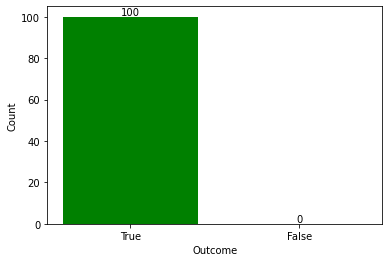

In [5]:
total_counts = {'00':0, '01':0, '10':0, '11':0}
for i in range(100):
    qc = computation_round(1,1)
    job = clean_simulator.run(qc,shots=100)
    counts = job.result().get_counts()
    result = [digit for digit in marginal_counts(counts,[6,14])][0][::-1]
    total_counts[result] += 1
    clear_output(wait=True)
    print('Running computation rounds... (' + str(i+1) + '%)')
clear_output(wait=True)
plot_histogram(total_counts, '10')

Let's test the capability of current IBM hardware to implement this pattern:

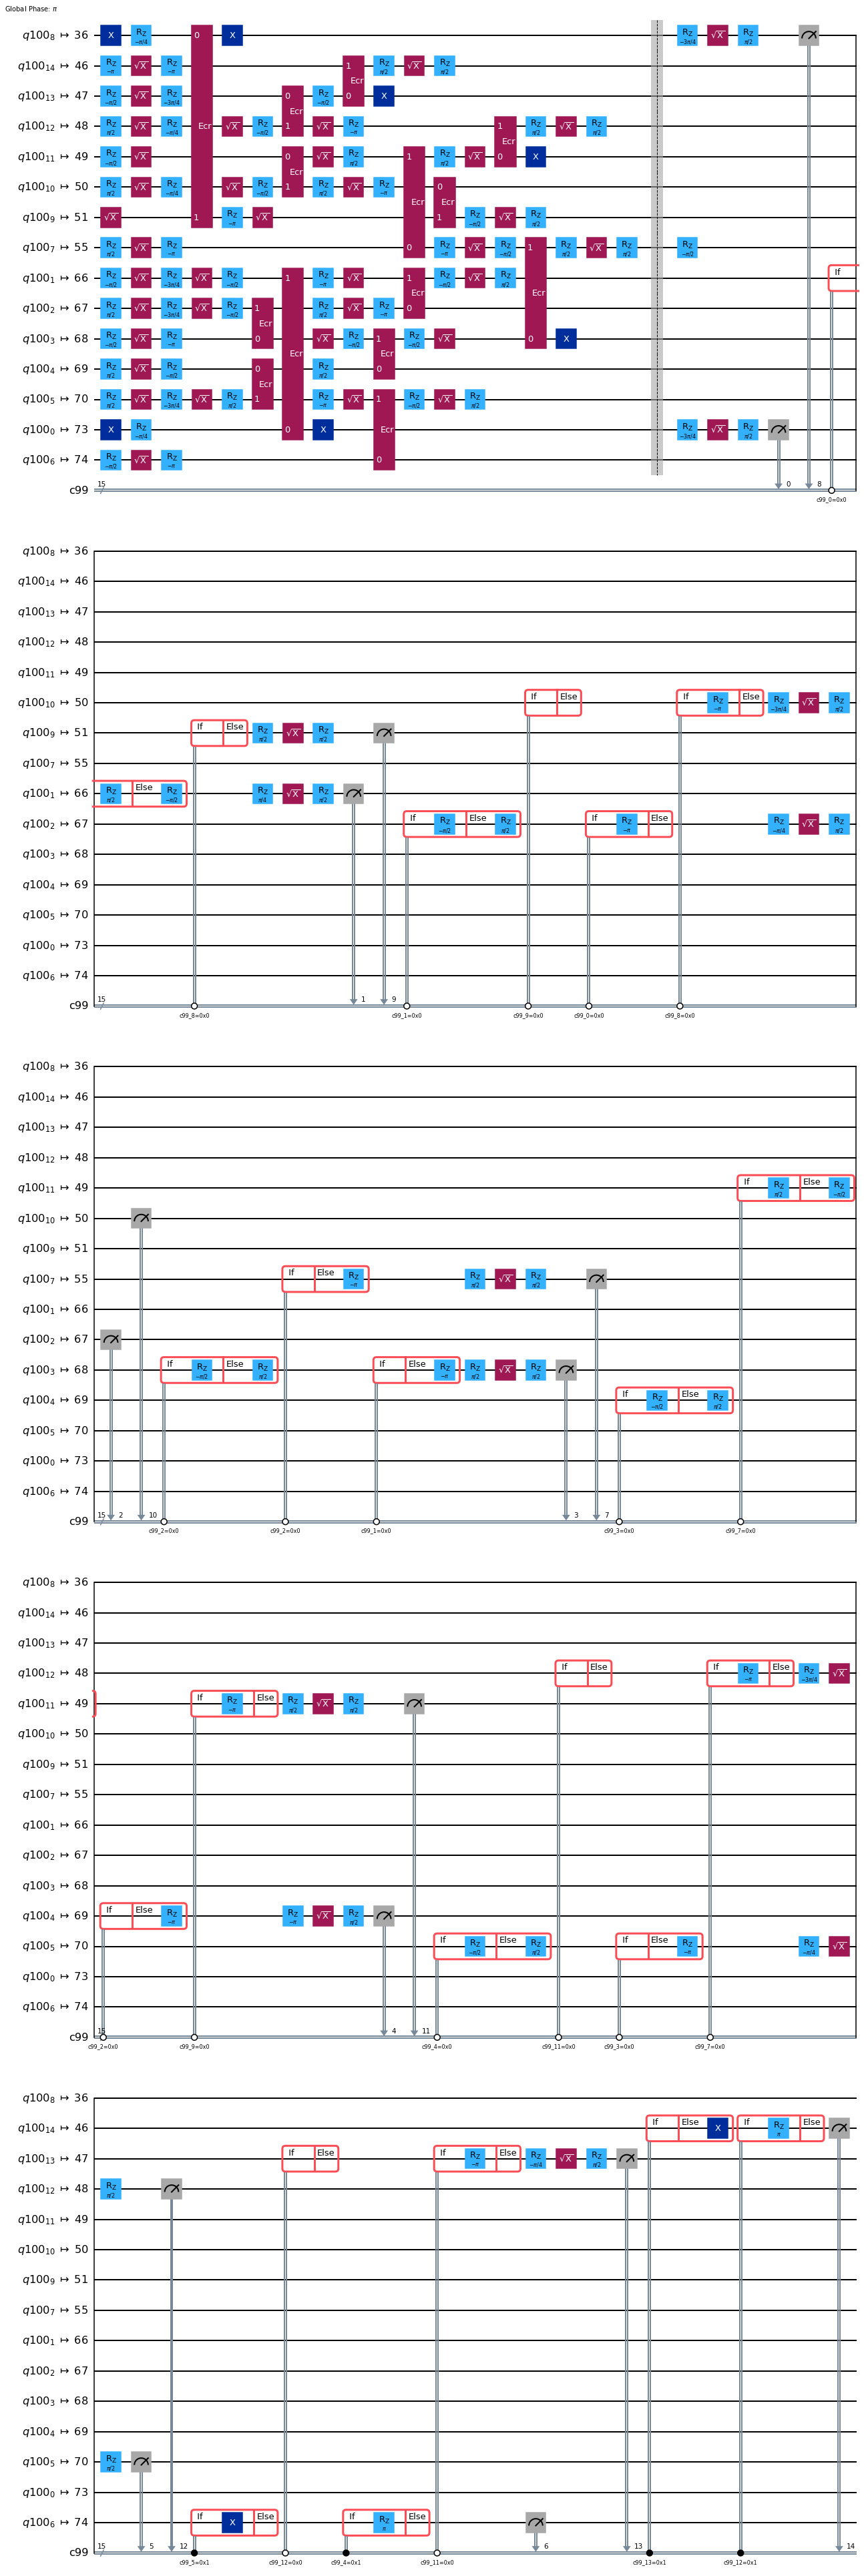

In [6]:
qc_trans = transpile(qc, hardware)
qc_trans.draw('mpl', idle_wires=False)

In [7]:
qc_trans.depth()

58

In [8]:
# job = hardware.run(qc_trans, shots=4096)
# job.job_id()

In [9]:
# job.status()

In [10]:
# job = service.job('cs7h0csbqt7g0082egn0')
# counts = job.result().get_counts()
# np.save('counts_cnot.npy', counts)

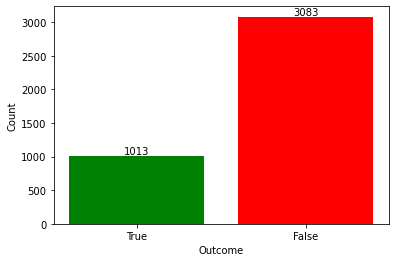

In [11]:
counts = np.load('counts_cnot.npy', allow_pickle=True).item()
#counts = job.result().get_counts()
marginals = marginal_counts(counts, [6, 14])
plot_histogram(marginals, '01') # Note we parse '01', not '10', due to Qiskit's reverse qubit ordering

We see ultimately that noise dominates on real hardware. Notably, we can produce an extractable signal if we remove the randomness and defer all measurements and corrections until the end (see the bottom of this notebook). This is not, however, of practical use to the basketing protocol. 

# Noise model

Since actual hardware noise dominates, we instead set up a fake noisy simulator using the real device's noise model and write a function to scale down the noise level. 

This makes use of the 'fake backend' noise models produced by IBM as simplified noise models for their devices. They take into account:
- The gate_error probability of each basis gate on each qubit.
- The gate_length of each basis gate on each qubit.
- The $T_1$, $T_2$ relaxation time constants of each qubit.
- The readout error probability of each qubit.

(See: https://qiskit.github.io/qiskit-aer/tutorials/2_device_noise_simulation.html)

Specifically, we use the backend noise model taken from the `ibm_sherbrooke` device. This function works simply by scaling each non-error probability by some global scale factor $s$ and adjusting the other probabilities proportionally. 

In [12]:
hardware_noise_model = NoiseModel.from_backend(hardware)
coupling_map = hardware.coupling_map

In [13]:
# Given a list of probabilities, the index of the non-error probability and a scale factor,
# scale the probabilities and return the new list
def scale_probs(p_list, index, scale_factor):
    p_no_error = p_list[index]
    n = len(p_list)
    p_new = max(min((1/n) + (p_no_error - 1/n)*scale_factor, 1), 0)
    for i in range(len(p_list)):
        if i == index:
            p_list[i] = p_new
        else:
            p_list[i] = p_list[i]*((1-p_new)/(1-p_no_error))
    return p_list

# Given a QiskitAer NoiseModel object and a scale factor,
# return the appropriately-scaled NoiseModel
def scale_noise_model(noise_model, scale_factor):

    # Convert to dictionary; look at the error part
    noise_dict = noise_model.to_dict()
    noise_dict_errors = noise_dict['errors']
    
    
    # 1. Find index of non-error instruction
    non_error_indices = [None]*len(noise_dict_errors)
    for error_i in range(len(noise_dict_errors)):
        error = noise_dict_errors[error_i]
        if 'instructions' in error:
            instructions_list = error['instructions']
            for instruction_i in range(len(instructions_list)):
                instruction = instructions_list[instruction_i]
                if sum([x['name']=='id' for x in instruction]) == len(instruction):
                    non_error_indices[error_i] = instruction_i
                
    # 2. Scale probs according to non-error term; otherwise remove them
    errors_to_remove = []
    for error_i in range(len(noise_dict_errors)):
        error = noise_dict_errors[error_i]
        if non_error_indices[error_i] == None: # Remove whole error term
            errors_to_remove.append(error)
        else:
            probs = error['probabilities']
            if all(isinstance(i, list) for i in probs): # If probs is list of lists, remove
                errors_to_remove.append(error)
            else:                                       # Otherwise, scale probs according to index of non-error term
                error['probabilities'] = scale_probs(probs, non_error_indices[error_i], scale_factor)
            noise_dict_errors[error_i] = error
    for error in errors_to_remove:
        noise_dict_errors.remove(error)
    
    noise_dict['errors'] = noise_dict_errors
    return NoiseModel.from_dict(noise_dict)


def get_noisy_simulator(scale_factor):
    
    noise_model = scale_noise_model(hardware_noise_model, scale_factor)
    return AerSimulator(coupling_map=coupling_map, noise_model=noise_model)

We can now observe how the outcomes of our computation rounds vary with the noise scale factor $s = 0.5, 0.75, 1$ (note we fix the randomness across all runs for each noise level for simplicity). 

C:\Users\joeh1\AppData\Local\Temp\ipykernel_1948\3189143688.py:51: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date.
  return NoiseModel.from_dict(noise_dict)


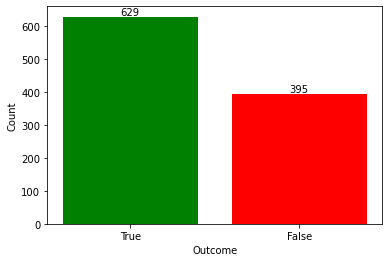

In [14]:
noisy_simulator = get_noisy_simulator(0.5)
job = noisy_simulator.run(qc, shots=1024)
counts = job.result().get_counts()
marginals = marginal_counts(counts, [6, 14])
plot_histogram(marginals, '01')

C:\Users\joeh1\AppData\Local\Temp\ipykernel_1948\3189143688.py:51: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date.
  return NoiseModel.from_dict(noise_dict)


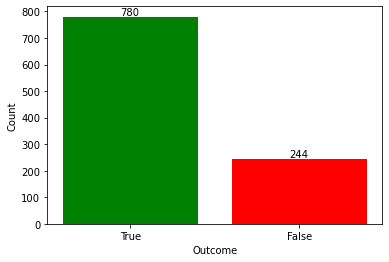

In [15]:
noisy_simulator = get_noisy_simulator(0.75)
job = noisy_simulator.run(qc, shots=1024)
counts = job.result().get_counts()
marginals = marginal_counts(counts, [6, 14])
plot_histogram(marginals, '01')

C:\Users\joeh1\AppData\Local\Temp\ipykernel_1948\3189143688.py:51: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date.
  return NoiseModel.from_dict(noise_dict)


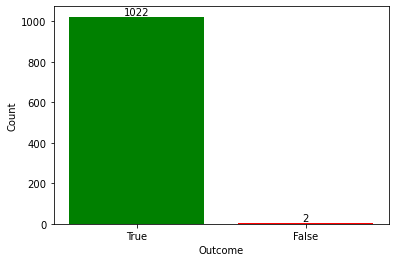

In [16]:
noisy_simulator = get_noisy_simulator(1)
job = noisy_simulator.run(qc, shots=1024)
counts = job.result().get_counts()
marginals = marginal_counts(counts, [6, 14])
plot_histogram(marginals, '01')

Note that $s=1$ is not noise free! 

# Test round design

Now we write a function to implement test rounds, using a $k=2$-colouring as shown at the top of this notebook. 

In [17]:
# Colour data
V0 = [1,3,5,9,11,13]
V1 = [0,2,4,6,8,10,7,12,14]
colouring_dict = {0: V0, 1: V1}

In [18]:
# Initialise test round circuit with full randomisation
def test_round():
    
    qr = QuantumRegister(15)
    cr = ClassicalRegister(15)
    qc = QuantumCircuit(qr,cr)
    
    j = np.random.choice([0,1])
    V_j = colouring_dict[j]
    theta_vs = {}
    d_vs = {}
    
    # Initialise individual qubit states:
    for i in range(15):
        if i in V_j: # If trap qubit
            theta_i = np.random.choice(range(8))*(pi/4)
            theta_vs[i] = theta_i
            qc.h(i)
            qc.rz(theta_i, i)
        else: # If dummy qubit
            d_i = np.random.choice([0,1])
            d_vs[i] = d_i
            if d_i == 1:
                qc.x(i)
                
    qc.barrier()
                
    # Server applies CZ gates along edges
    for edge in E:
        qc.cz(edge[0],edge[1])
    
    qc.barrier()
    
    
    # Measurements
    mmt_outcomes = [0]*15
    r_vs = [0]*15
    for i in [0,8,1,9,2,10,3,7,11,4,12,5,13,6,14]:
        if i in V_j:
            r_v = np.random.choice([0,1])
            r_vs[i] = r_v
            delta_v = theta_vs[i] + r_v*pi
        else:
            delta_v = np.random.choice(range(8))*(pi/4)
            
        qc.rz(-delta_v,i)
        qc.h(i)
        qc.measure(i,i)
        
    
    boolean_data = [V_j, r_vs, d_vs]
    
    return qc, boolean_data

In [19]:
# Given vertex and list of edges, return the neighbours of that vertex in graph dictated by those edges
def neighbours(v, edges):
    nbs = []
    for v1, v2 in edges:
        if v1 == v:
            nbs.append(v2)
        elif v2 == v:
            nbs.append(v1)
    return nbs

In [20]:
# Take measurement outcome and verify if test round passed
# Outcome ordered so that first digit is outcome of q0, etc.
def verify_test(outcome, boolean_data):
    
    V_j, r_vs, d_vs = boolean_data
    
    for v in V_j:
        
        b_v = int(outcome[v])
        r_v = r_vs[v]
        nbs = neighbours(v, E)
        S = sum([d_vs[nb] for nb in nbs]) % 2 # sum d_i over neighbours of v
        
        if b_v != ((r_v + S) % 2):
            return False
    
    return True

In [21]:
def plot_test_results(results):
    labels = ['True', 'False']
    values = [results[True], results[False]]
    colors = ['lightgreen', 'lightcoral']
    bars = plt.bar(labels, values, color=colors)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom')
    return plt.show()

We first check that our test rounds work in a noiseless environment:

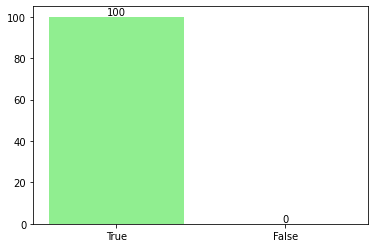

In [22]:
test_round_test_results = {True: 0, False: 0}
for i in range(100):
    qc_test, boolean_data = test_round()
    job = clean_simulator.run(qc_test,shots=1)
    counts = job.result().get_counts()
    outcome = [i for i in counts][0][::-1]
    test_round_test_results[verify_test(outcome, boolean_data)] += 1
    
plot_test_results(test_round_test_results)

# Simulating time-dependent fluctuating noise

We first perform some analysis as to how the success rate of our test rounds scales with the noise level.

C:\Users\joeh1\AppData\Local\Temp\ipykernel_1948\3189143688.py:51: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date.
  return NoiseModel.from_dict(noise_dict)


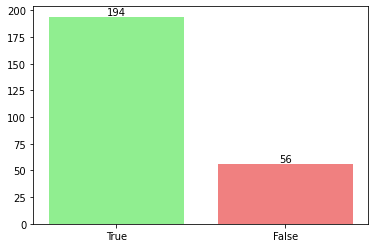

In [23]:
noisy_simulator = get_noisy_simulator(0.8)

qc_list = []
boolean_data_list = []
for i in range(250):
    qc_test, boolean_data = test_round()
    qc_list.append(qc_test)
    boolean_data_list.append(boolean_data)
    
job = noisy_simulator.run(qc_list,shots=1)
counts = job.result().get_counts()

test_round_test_results = {True: 0, False: 0}
for j in range(250):
    outcome = [i for i in counts[j]][0][::-1]
    test_round_test_results[verify_test(outcome, boolean_data_list[j])] += 1
    
plot_test_results(test_round_test_results)

C:\Users\joeh1\AppData\Local\Temp\ipykernel_1948\3189143688.py:51: DeprecationWarning: from_dict has been deprecated as of qiskit-aer 0.10.0 and will be removed no earlier than 3 months from that release date.
  return NoiseModel.from_dict(noise_dict)


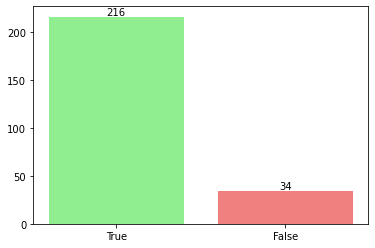

In [24]:
noisy_simulator = get_noisy_simulator(0.9)

qc_list = []
boolean_data_list = []
for i in range(250):
    qc_test, boolean_data = test_round()
    qc_list.append(qc_test)
    boolean_data_list.append(boolean_data)
    
job = noisy_simulator.run(qc_list,shots=1)
counts = job.result().get_counts()

test_round_test_results = {True: 0, False: 0}
for j in range(250):
    outcome = [i for i in counts[j]][0][::-1]
    test_round_test_results[verify_test(outcome, boolean_data_list[j])] += 1
    
plot_test_results(test_round_test_results)

To obtain good convergence of Subroutine 3, allowing us to run effective basketing with feasible numbers of rounds, we require a test round failure rate of approximately $0.15$ or better. 


Test round simulations with $s = 0.9$ appear to have a failure rate close to $0.15$, while at $s=0.8$ the failure rate is significantly worse. This inspires us to model our fluctuating noise via our scaling parameter taking a random walk in $[0.8,1]$, starting at $0.9$ and moving in increments of $0.01$ every $1000$ (test or computation) rounds. This is designed to mimic device noise that varies between jobs, where each job runs a circuit with approximately $1000$ shots, but is an arbitrary choice. Our aim is to then post-select on those periods of time where the failure rate is below $0.15$ for a large number of consecutive shots, allowing for good convergence of Subroutine 3. 

In [25]:
# Fix randomness so outcomes can be replicated
np.random.seed(12)

In [26]:
# Simulate a random walk, starting at the midpoint between the min/max
# and moving by 0.01 every 1000 time steps
def sigma_walk(num_rounds, noise_min, noise_max):
    
    sigma_list = [round((noise_min+noise_max)/2,2)] + [0]*(num_rounds-1)
    sigma = round((noise_min+noise_max)/2,2)
    for i in range(num_rounds-1):
        if i % 1000 == 0:
            if round(sigma, 2) == noise_min:
                sigma = np.random.choice([noise_min+0.01,noise_min])
            elif round(sigma, 2) == noise_max:
                sigma = np.random.choice([noise_max,noise_max-0.01])
            else:
                sigma = sigma + np.random.choice([-1,1])*0.01

        sigma_list[i+1] = round(sigma, 2)
    
    return sigma_list

# Basketing

We now run our basketing procedure by performing the steps as detailed in Protocol 1 of the main text. 

1. We set $\varepsilon_\text{target} = 0.05$, $p_\text{max} = \tilde{p} = 0.15$ and run Subroutine 3, varying the initial value of $n$. We find we have convergence when we set $n=10,000$ initially, and the subroutine returns $\tau = 0.9$. This suggests that we should aim to produce baskets of a size close to $N=10,000$. 

2. We pick $N' = 10N = 100,000$. Hence we will run $\tau N' = 90,0000$ test rounds and $(1-\tau)N' = 10,000$ computation rounds.

In [27]:
# Randomly order rounds
# rounds = ['t']*90000 + ['c']*10000
# np.random.shuffle(rounds)

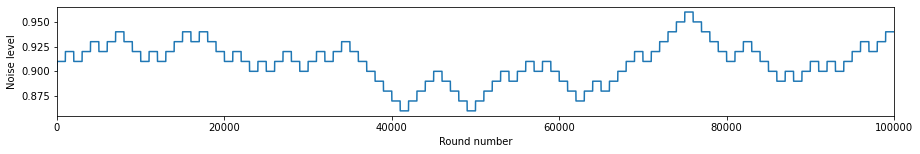

In [28]:
# Generate fluctuating noise over 100,000 timesteps
plt.figure(figsize=(15,2))
num_steps = 100000
noise_walk = sigma_walk(num_steps, 0.8, 1)
plt.plot(noise_walk)
plt.xlim([0,num_steps])
plt.xlabel('Round number')
plt.ylabel('Noise level')
np.save('noise_walk.npy',noise_walk)

3. We run the rounds using our simulator using only one group $G = \{1,2,\dots,100,000\}$. The fastest way to simulate this is actually to run all the rounds for each fixed noise level at once:

In [29]:
# # Generate all the noisy simulators we need first; store them in a list
# noisy_sims_list = []
# noises_list = np.linspace(0.8,1,21)
# for i in range(21):
#     noisy_sims_list.append(get_noisy_simulator(noises_list[i]))
#     clear_output(wait=True)
#     print('done for i = ' + str(i))

In [30]:
# # Group rounds by noise level

# rounds_by_noise = {}
# for noise in np.linspace(0.8,1,21):
#     rounds_by_noise[round(noise,2)] = []
    
# for i in range(100000):
#     noise = round(noise_walk[i], 2)
#     rounds_list = rounds_by_noise[noise]
#     rounds_list.append([i,rounds[i]])
    
# print(rounds_by_noise[0.9][0:5])

In [31]:
# # For each noise level, prepare and run the corresponding rounds

# test_round_boolean_data = [None]*100000
# round_counts = [None]*100000

# # For each noise level
# for noise in np.linspace(0.8,1,21):
    
#     noise = round(noise, 2)
    
#     # If there are rounds to run at this noise level
#     if len(rounds_by_noise[noise]) > 0:

#         clear_output(wait=True)
#         print('Preparing jobs... (noise = ' + str(noise) + ')')

#         rounds_to_run = rounds_by_noise[noise]

#         # Prepare circs to run at this noise level
#         qcs_list = []
#         for round_int, round_type in rounds_to_run:
#             if round_type == 't':
#                 qc_test, boolean_data = test_round()
#                 qcs_list.append(qc_test)
#                 test_round_boolean_data[round_int] = boolean_data
#             else:
#                 qcs_list.append(computation_round(1,1))

#         # Run circs
#         noisy_simulator = noisy_sims_list[int(100*noise-80)]

#         clear_output(wait=True)
#         print('Running jobs... (noise = ' + str(noise) + ')')

#         job = noisy_simulator.run(qcs_list, shots=1)

#         # Save job counts
#         counts = job.result().get_counts()

#         clear_output(wait=True)
#         print('Postprocessing jobs... (noise = ' + str(noise) + ')')

#         for i in range(len(counts)):
#             round_int = rounds_to_run[i][0]
#             round_counts[round_int] = counts[i]

#     np.save('basketing_round_counts.npy', round_counts, allow_pickle=True)
#     np.save('basketing_test_round_boolean_data.npy', np.array(test_round_boolean_data, dtype='object'), allow_pickle=True)

# clear_output(wait=True)
# print('Postprocessing jobs... (noise = ' + str(noise) + ')')

In [32]:
# Load data from above
round_counts = np.load('basketing_round_counts.npy', allow_pickle=True)
test_round_boolean_data = np.load('basketing_test_round_boolean_data.npy', allow_pickle=True)

4. We format our results as a single list where the $i$th element shows the result of the $i$th round, test or computation. The computation results are two-digit binary strings and the test results are Boolean. 

In [33]:
# Process results of rounds into a list containing either pass/fail (test rounds)
# or the final 2q mmt outcome (computation rounds)

round_results = [None]*100000
for i in range(100000):
    counts = round_counts[i]
    if test_round_boolean_data[i] is None: # Computation round
        marginals = marginal_counts(counts, [6, 14])
        outcome = [i for i in marginals][0][::-1]
        round_results[i] = outcome
    else: # Test round
        outcome = [i for i in counts][0][::-1]
        test_result = verify_test(outcome, test_round_boolean_data[i])
        round_results[i] = test_result
        
print(round_results[-10:])

['10', True, True, True, True, False, True, True, True, True]


In [34]:
# Given a list of round results (test and computation),
# return the average pass rate of the test rounds
def test_round_pass_rate(round_results):
    counter = 0
    total = 0
    for i in range(len(round_results)):
        if round_results[i] in [True, False]:
            total += round_results[i]
            counter += 1
    return total/counter

# Given a list of round results (test and computation),
# tally the computation round results
def comp_round_results(round_results):
    results = {'00':0, '01':0, '10':0, '11':0}
    for i in range(len(round_results)):
        if round_results[i] not in [True, False]:
            results[round_results[i]] += 1
    return results

5. We use our test result data to plot the average test round pass rate at each time step, sampled over the nearest $T=1000$ rounds since we expect the noise to fluctuate at about this rate. 

In [35]:
# Create list of average test round pass rate at each time step
pass_rates = [None]*100000
sampling_rate = 1000
half_sampling_rate = int(np.floor(sampling_rate/2))
for i in range(100000):
    pass_rates[i] = test_round_pass_rate(round_results[max(i-half_sampling_rate,0):min(i+half_sampling_rate,100000)])

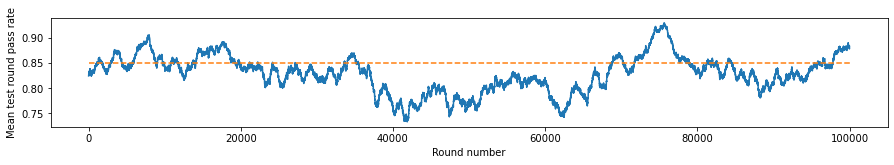

In [36]:
boundary = 0.85
plt.figure(figsize=(15,2))
plt.plot(pass_rates)
plt.xlabel('Round number')
plt.ylabel('Mean test round pass rate')
plt.plot([0,100000],[boundary,boundary],'--')

6. We identify our 'baskets' by picking those regions where the average test round pass rate is above the boundary value of 0.85 (i.e. the failure rate is below 0.15) for at least 5000 consecutive rounds. The number of consecutive rounds is an arbitrary choice and can be varied depending on one's own results -- we choose 5000 since this results in two clear baskets and allows the subroutine to converge: 

In [37]:
# Identify those regions where the pass rate is at least the boundary value of 0.85 
# (i.e. the failure rate is below 0.15) for at least 5000 consecutive rounds
last_change = 0
for i in range(100000):
    if i < 100000-1:
        if pass_rates[i] < boundary and pass_rates[i+1] >= boundary: 
            last_change = i  
        if pass_rates[i] >= boundary and pass_rates[i+1] < boundary:
            if i - last_change >= 5000:
                print(str(last_change) + ' to ' + str(i) + '  (' + str(i-last_change) + ' rounds)')
            last_change = i
    elif i == 100000-1 and pass_rates[i] > boundary and i - last_change >= 5000:
        print(str(last_change) + ' to ' + str(i) + '  (' + str(i-last_change) + ' rounds)')

14079 to 19277  (5198 rounds)
71721 to 78539  (6818 rounds)


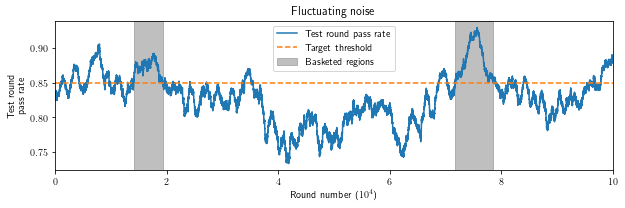

In [38]:
plt.rcParams['text.usetex'] = True
x = [i/10000 for i in range(100000)]
boundary = 0.85
plt.figure(figsize=(10,2.75))
plt.plot(x, pass_rates)
plt.xlabel('Round number ($10^4$)')
plt.ylabel('Test round\n pass rate')
plt.plot([0,10],[boundary,boundary],'--')
plt.axvspan(1.4079, 1.9277, color='gray', alpha=0.5)
plt.axvspan(7.1721, 7.8539, color='gray', alpha=0.5)
plt.xlim([0,10])
plt.legend(['Test round pass rate','Target threshold','Basketed regions'])
plt.title('Fluctuating noise');
# plt.savefig('basketing_plot.pdf', bbox_inches='tight')

7. We firstly determine the value of $Q_i$ for each basket (where $Q_i = 1$ if the majority of outcomes are $10$ and $0$ otherwise). We then identify the precise proportions of test rounds $\tau_i$ in each of the two baskets. Then, we run Subroutine 3 separately for each basket, minimising $\epsilon_\text{max}$ subject to $n$ (the number of rounds in the basket), $p = 0, p_\text{max}=0.15, k=2, \tau = 0.90$ and obtain $\epsilon_\text{max} = 0.173, 0.079$ for the two baskets listed above. Noteably, the threshold values $\Phi$ are both above our pre-determined minimum permitted error rate of $0.15$.

In [39]:
baskets = [round_results[14079:19293],round_results[71721:78538]]
for i in range(len(baskets)):
    counters = {'00': 0, '01': 0, '10': 0, '11': 0}
    basket = [x for x in baskets[i] if x not in [True, False]]
    for result in basket:
        if result not in [True, False]:
            counters[result] += 1
    for comp_result in counters:
        if counters[comp_result] > len(basket)/2:
            print(f'Q_{i+1} =', int(comp_result == '10'))

Q_1 = 1
Q_2 = 1


In [40]:
for i in range(len(baskets)):
    test_counter = 0
    basket = baskets[i]
    for result in basket:
        if result in [True, False]:
            test_counter += 1
    print(f'tau_{i+1} =', str(test_counter/len(basket)))

tau_1 = 0.9004602991944765
tau_2 = 0.8976089188792724


In [41]:
# We run the minimiser with intial conditions x = [n,0,0.15,2,0.90,0.15,0.01,0.01,0.1]
# and fix tau = 0.9, giving the following results:

# n = 5214
# p = 0.0
# p_max = 0.15
# k = 2.0
# tau = 0.9
# psi = 0.13037154539610363
# e1 = 0.011175307110777388
# e2 = 0.026973335526797943
# e3 = 0.08923367663383804
# Phi = 0.1695578967285908
# eps = 0.1726877059139294 <--

# n = 6817
# p = 0.0
# p_max = 0.15
# k = 2.0
# tau = 0.9
# psi = 0.13095073934660337
# e1 = 0.010356234590806545
# e2 = 0.028584341456843493
# e3 = 0.09339527296531872
# Phi = 0.1690935090961335
# eps = 0.0791770342219737 <-- 

In [42]:
# Each of the baskets gives the outcome 10 with respective success probabilities
p1 = 1 - 0.1726877059139294
p2 = 1 - 0.0791770342219737
Ps = [p1, p2]

8. Finally, we can combine these probabilities using Bayesian updating with a prior probability of $1/2$.

In [43]:
# We can combine these probabilities using Bayesian updating, 
# making the overall probability 
p_current = 0.5
for p in Ps:
    p_new = (p*p_current)/(p*p_current + (1-p)*(1-p_current))
    p_current = p_new
print(p_current)

0.9823684921600511


Thus, we obtain $10$ as the correct outcome with $98.2\%$ probability, within our target success probablity of $1-\varepsilon_\text{target}=95\%$.

---

# Non-fluctuating noise case

We repeat the analysis above for a time-independent noise with a fixed noise level of 0.9, the midpoint of the permitted noise levels in the fluctuating case. The only difference in code versus the case above is that we set `noise_walk = [0.9]*100000` and change the filenames where we save our results

In [44]:
# Load data from above
round_counts_nf = np.load('basketing_round_counts_nonfluctuating.npy', allow_pickle=True)
test_round_boolean_data_nf = np.load('basketing_test_round_boolean_data_nonfluctuating.npy', allow_pickle=True)

In [45]:
# Process results of rounds into a list containing either pass/fail (test rounds)
# or the final 2q mmt outcome (computation rounds)

round_results_nf = [None]*100000
for i in range(100000):
    counts = round_counts_nf[i]
    if test_round_boolean_data_nf[i] is None: # Computation round
        marginals = marginal_counts(counts, [6, 14])
        outcome = [i for i in marginals][0][::-1]
        round_results_nf[i] = outcome
    else: # Test round
        outcome = [i for i in counts][0][::-1]
        test_result = verify_test(outcome, test_round_boolean_data_nf[i])
        round_results_nf[i] = test_result

In [46]:
# Create list of average test round pass rate at each time step
pass_rates_nf = [None]*100000
for i in range(100000):
    pass_rates_nf[i] = test_round_pass_rate(round_results_nf[max(i-half_sampling_rate,0):min(i+half_sampling_rate,100000)])

In [47]:
# Identify those regions where the pass rate is at least the boundary value for at least 5000 consecutive rounds
last_change = 0
for i in range(100000):
    if i < 100000-1:
        if pass_rates_nf[i] < boundary and pass_rates_nf[i+1] >= boundary: 
            last_change = i  
        if pass_rates_nf[i] >= boundary and pass_rates_nf[i+1] < boundary:
            if i - last_change >= 5000:
                print(str(last_change) + ' to ' + str(i) + '  (' + str(i-last_change) + ' rounds)')
            last_change = i
    elif i == 100000-1 and pass_rates_nf[i] > boundary and i - last_change >= 5000:
        print(str(last_change) + ' to ' + str(i) + '  (' + str(i-last_change) + ' rounds)')

Since the cell above does not print anything, we see we are unable to identify any baskets in the non-fluctuating noise case:

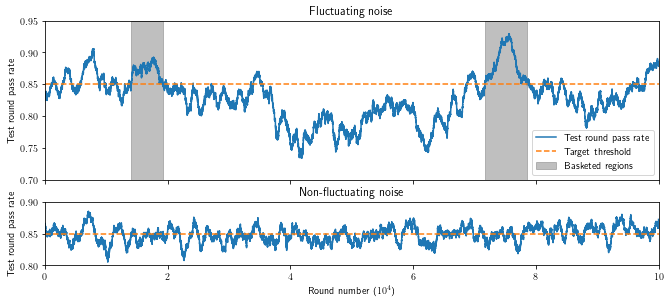

In [48]:
from matplotlib.ticker import MultipleLocator

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 4.5), sharex=True,  gridspec_kw={'height_ratios': [5, 2]})

ax1.plot(x, pass_rates)
ax1.set_ylabel('Test round pass rate') 
ax1.plot([0,10],[boundary,boundary],'--')
ax1.axvspan(1.4079, 1.9277, color='gray', alpha=0.5)
ax1.axvspan(7.1721, 7.8539, color='gray', alpha=0.5)
ax1.set_xlim([0,10])
ax1.set_ylim([0.7,0.95])
ax1.legend(['Test round pass rate','Target threshold','Basketed regions'])
ax1.set_title('Fluctuating noise')

ax2.plot(x, pass_rates_nf)
ax2.set_ylabel('Test round pass rate') 
ax2.set_xlabel('Round number ($10^4$)')
ax2.plot([0,10],[boundary,boundary],'--')
ax2.set_title('Non-fluctuating noise')
ax2.set_xlim([0,10])
ax2.set_ylim([0.8,0.9])
ax2.yaxis.set_major_locator(MultipleLocator(0.05))

plt.savefig('basketing_plot_combined.pdf', bbox_inches='tight')

---

Bonus: by removing blindness and only processing corrections at the end (see e.g. [here](https://github.com/PaddlePaddle/Quantum/blob/master/tutorials/mbqc/MBQC_EN.ipynb)), we can run computation rounds on current hardware with an extractable signal:

In [49]:
# Construct a standard round with no randomisation

def standard_round_old():
    qr = QuantumRegister(15)
    cr = ClassicalRegister(15)
    qc = QuantumCircuit(qr,cr)
   
    # Input qubits in 1 state
    qc.x([0,8])
    
    # Other qubits in + state
    qc.h([1,2,3,4,5,6,7,9,10,11,12,13,14])
    
    # CZs along edges
    for edge in E:
        qc.cz(edge[0],edge[1])
    
    qc.barrier()
    
    # Measure each non-output qubit at given angle
    for i in range(15):
        if i != 6 and i != 14:
            qc.rz(-angles[i],i)
            qc.h(i)
            qc.measure(i,i)
        
    qc.barrier()
    
    # Correct output qubits 
    
    # X on control
    with qc.if_test((cr[1], 1)):
        qc.x(6)
    with qc.if_test((cr[2], 1)):
        qc.x(6)
    with qc.if_test((cr[4], 1)):
        qc.x(6)
    with qc.if_test((cr[5], 1)):
        qc.x(6)
        
    # X on target
    with qc.if_test((cr[1], 1)):
        qc.x(14)
    with qc.if_test((cr[2], 1)):
        qc.x(14)
    with qc.if_test((cr[7], 1)):
        qc.x(14)
    with qc.if_test((cr[9], 1)):
        qc.x(14)
    with qc.if_test((cr[11], 1)):
        qc.x(14)
    with qc.if_test((cr[13], 1)):
        qc.x(14)
        
        
# ------------ Z corrections not needed for classical inputs
        
#     # Z on control
#     with qc.if_test((cr[0], 1)):
#         qc.z(6)
#     with qc.if_test((cr[2], 1)):
#         qc.z(6)
#     with qc.if_test((cr[3], 1)):
#         qc.z(6)
#     with qc.if_test((cr[4], 1)):
#         qc.z(6)
#     with qc.if_test((cr[7], 1)):
#         qc.z(6)
#     with qc.if_test((cr[8], 1)):
#         qc.z(6)    
#     with qc.if_test((cr[10], 1)):
#         qc.z(6)
#     qc.z(6)
    
#     # Z on target
#     with qc.if_test((cr[8], 1)):
#         qc.z(14)
#     with qc.if_test((cr[10], 1)):
#         qc.z(14)
#     with qc.if_test((cr[12], 1)):
#         qc.z(14)
        
        
    qc.measure(6,6)
    qc.measure(14,14)
    
    return qc

In [50]:
qc = standard_round_old()
qc_trans = transpile(qc, hardware)
qc_trans.count_ops()

OrderedDict([('rz', 76),
             ('sx', 44),
             ('measure', 15),
             ('ecr', 14),
             ('if_else', 10),
             ('x', 4),
             ('barrier', 2)])

In [51]:
qc_trans.depth()

27

In [52]:
# job = hardware.run(qc_trans, shots=1024)
# job.job_id()

In [53]:
# job = service.job('job_ID_here')
# counts = job.result().get_counts()
# np.save('counts_cnot_delayed_mmt.npy', counts)

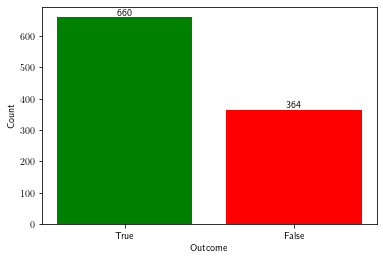

In [54]:
counts = np.load('counts_cnot_delayed_mmt.npy', allow_pickle=True).item()
marginals = marginal_counts(counts, [6, 14])
plot_histogram(marginals, '01')